In [ ]:
import platform, sys, os
if 'google.colab' in sys.modules:
    # install PyGMTSAR stable version from PyPI
    !{sys.executable} -m pip install -q pygmtsar
    # alternatively, nstall PyGMTSAR development version from GitHub
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    # use PyGMTSAR Google Colab installation script to install binary dependencies
    # script URL: https://github.com/AlexeyPechnikov/pygmtsar/blob/pygmtsar2/pygmtsar/pygmtsar/data/google_colab.sh
    import importlib.resources as resources
    with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
        !sh {google_colab_script_filename}
    # enable custom widget manager as required by recent Google Colab updates
    from google.colab import output
    output.enable_custom_widget_manager()
    # initialize virtual framebuffer for interactive 3D visualization; required for headless environments
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

# specify GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# display PyGMTSAR version
from pygmtsar import __version__
__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.6 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)




update-alternatives: using /usr/bin/gcc-9 to provide /usr/bin/gcc (gcc) in auto mode
There is only one alternative in link group gcc (providing /usr/bin/gcc): /usr/bin/gcc-9
Noth

'2025.4.8.post1'

## Load and Setup Python Modules

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from dask.distributed import Client
import dask
import json
import warnings
import logging
# supress warning "Detected different `run_spec` for key"
logging.getLogger("distributed.scheduler").setLevel(logging.ERROR)

In [ ]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')
from contextlib import contextmanager
# plotting modules
import matplotlib.pyplot as plt
import matplotlib
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
from ipyleaflet import Map, GeoJSON, TileLayer, LayersControl, basemaps, Popup
from ipywidgets import HTML
%matplotlib inline

In [ ]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles

## Define Sentinel-1 SLC Scenes and Processing Parameters

In [ ]:
SCENES = [
'S1_056057_IW1_20180308T125714_VV_D18D-BURST',
'S1_056057_IW1_20180320T125714_VV_4F60-BURST',
'S1_056057_IW1_20180401T125714_VV_37FD-BURST',
'S1_056057_IW1_20180413T125715_VV_54BE-BURST',
'S1_056057_IW1_20180425T125715_VV_AFCD-BURST',
'S1_056057_IW1_20180507T125716_VV_BFCB-BURST',
'S1_056057_IW1_20180519T125716_VV_5A7C-BURST',
'S1_056057_IW1_20180531T125717_VV_889C-BURST',
'S1_056057_IW1_20180612T125718_VV_76AF-BURST',
'S1_056057_IW1_20180624T125718_VV_90BC-BURST',
'S1_056057_IW1_20180718T125720_VV_6174-BURST',
'S1_056057_IW1_20180730T125721_VV_210C-BURST',
'S1_056057_IW1_20180811T125721_VV_8CC3-BURST',
'S1_056057_IW1_20180823T125722_VV_B733-BURST',
'S1_056057_IW1_20180904T125723_VV_128C-BURST',
'S1_056057_IW1_20180916T125723_VV_A41E-BURST',
'S1_056057_IW1_20180928T125723_VV_40A7-BURST',
'S1_056057_IW1_20181010T125724_VV_582D-BURST',
'S1_056057_IW1_20181022T125724_VV_1553-BURST',
'S1_056057_IW1_20181103T125724_VV_7313-BURST',
'S1_056057_IW1_20181115T125723_VV_70BA-BURST',
'S1_056057_IW1_20181127T125723_VV_0978-BURST',
'S1_056057_IW1_20181209T125722_VV_69E9-BURST',
'S1_056057_IW1_20181221T125722_VV_B994-BURST',
'S1_056057_IW1_20190102T125722_VV_32B3-BURST',
'S1_056057_IW1_20190114T125721_VV_6C57-BURST',
'S1_056057_IW1_20190126T125721_VV_C5E8-BURST',
'S1_056057_IW1_20190207T125720_VV_69F9-BURST',
'S1_056057_IW1_20190219T125720_VV_5BDF-BURST',
'S1_056057_IW1_20190303T125720_VV_9960-BURST',
'S1_056057_IW1_20190315T125720_VV_8B6F-BURST',
'S1_056057_IW1_20190327T125720_VV_99C1-BURST',
'S1_056057_IW1_20190408T125721_VV_36BE-BURST',
'S1_056057_IW1_20190420T125721_VV_82FF-BURST',
'S1_056057_IW1_20190502T125722_VV_4833-BURST',
'S1_056057_IW1_20190514T125722_VV_8930-BURST',
'S1_056057_IW1_20190526T125723_VV_394F-BURST',
'S1_056057_IW1_20190607T125723_VV_BDA7-BURST',
'S1_056057_IW1_20190619T125724_VV_7380-BURST',
'S1_056057_IW1_20190701T125725_VV_9BED-BURST',
'S1_056057_IW1_20190713T125726_VV_B61A-BURST',
'S1_056057_IW1_20190725T125726_VV_DFDB-BURST',
'S1_056057_IW1_20190806T125727_VV_1588-BURST',
'S1_056057_IW1_20190818T125728_VV_D4CB-BURST',
'S1_056057_IW1_20190830T125728_VV_E8E0-BURST',
'S1_056057_IW1_20190911T125729_VV_AEE7-BURST',
'S1_056057_IW1_20190923T125730_VV_AF54-BURST',
'S1_056057_IW1_20191005T125730_VV_C0DF-BURST',
'S1_056057_IW1_20191017T125730_VV_CF54-BURST',
'S1_056057_IW1_20191029T125730_VV_C63F-BURST',
'S1_056057_IW1_20191110T125730_VV_B68F-BURST',
'S1_056057_IW1_20191122T125730_VV_1703-BURST',
'S1_056057_IW1_20191204T125729_VV_C043-BURST',
'S1_056057_IW1_20191216T125729_VV_D137-BURST',
'S1_056057_IW1_20191228T125728_VV_6C38-BURST',
'S1_056057_IW1_20200109T125728_VV_F9C9-BURST',
'S1_056057_IW1_20200121T125727_VV_DF14-BURST',
'S1_056057_IW1_20200202T125727_VV_BF9D-BURST',
'S1_056057_IW1_20200214T125726_VV_BAB4-BURST',
'S1_056057_IW1_20200226T125726_VV_D3D9-BURST',
'S1_056057_IW1_20200309T125726_VV_0511-BURST',
'S1_056057_IW1_20200321T125727_VV_1154-BURST',
'S1_056057_IW1_20200402T125727_VV_5992-BURST',
'S1_056057_IW1_20200414T125727_VV_735C-BURST',
'S1_056057_IW1_20200426T125728_VV_9377-BURST',
'S1_056057_IW1_20200508T125728_VV_048A-BURST',
'S1_056057_IW1_20200520T125729_VV_FE16-BURST',
'S1_056057_IW1_20200601T125730_VV_7282-BURST',
'S1_056057_IW1_20200613T125731_VV_D93F-BURST',
'S1_056057_IW1_20200625T125731_VV_6257-BURST',
'S1_056057_IW1_20200707T125732_VV_7C89-BURST',
'S1_056057_IW1_20200719T125733_VV_3F3A-BURST',
'S1_056057_IW1_20200731T125733_VV_3E95-BURST',
'S1_056057_IW1_20200812T125734_VV_916C-BURST',
'S1_056057_IW1_20200824T125735_VV_D484-BURST',
'S1_056057_IW1_20200905T125735_VV_BE9B-BURST',
'S1_056057_IW1_20200917T125736_VV_2B71-BURST',
'S1_056057_IW1_20200929T125736_VV_372F-BURST',
'S1_056057_IW1_20201011T125736_VV_5383-BURST',
'S1_056057_IW1_20201023T125736_VV_78E1-BURST',
'S1_056057_IW1_20201104T125736_VV_5E94-BURST',
'S1_056057_IW1_20201116T125736_VV_3B64-BURST',
'S1_056057_IW1_20201128T125735_VV_655E-BURST',
'S1_056057_IW1_20201210T125735_VV_3008-BURST',
'S1_056057_IW1_20201222T125735_VV_E0DD-BURST',
'S1_056057_IW1_20210103T125734_VV_EEE7-BURST',
'S1_056057_IW1_20210115T125733_VV_FAE2-BURST',
'S1_056057_IW1_20210127T125733_VV_B16E-BURST',
'S1_056057_IW1_20210208T125733_VV_0B6F-BURST',
'S1_056057_IW1_20210220T125732_VV_CA29-BURST',
'S1_056057_IW1_20210304T125732_VV_F838-BURST',
'S1_056057_IW1_20210316T125732_VV_C3C2-BURST',
'S1_056057_IW1_20210328T125733_VV_3631-BURST',
]

In [ ]:
# from datetime import datetime
# def extract_date(scene):
#     date_str = scene.split('_')[3][:8]
#     return datetime.strptime(date_str, '%Y%m%d')

# def is_excluded_date(date):
#     month = date.month
#     day = date.day
#     return (month == 11 and day >= 15) or (month == 12) or (month <= 2) or (month == 3 and day <= 15)
# filtered_scenes = [scene for scene in SCENES if not is_excluded_date(extract_date(scene))]
# tile_id = filtered_scenes[0].split('_')[0] + '_' + filtered_scenes[0].split('_')[1]
# mid_season_target = datetime.strptime('20200715', '%Y%m%d')
# min_diff = float('inf')
# selected_reference = None
# for scene in filtered_scenes:
#     date = extract_date(scene)
#     diff = abs((date.replace(year=2020) - mid_season_target).days)
#     if diff < min_diff:
#         min_diff = diff
#         selected_reference = date.strftime('%Y-%m-%d')

# print(f"Original list size: {len(SCENES)}")
# print(f"Filtered list size: {len(filtered_scenes)}")
# print(f"Tile ID: {tile_id}")
# print(f"Selected reference date: {selected_reference}")

In [ ]:
# SCENES = filtered_scenes
# tile_id = SCENES[0].split('_')[0] + '_' + SCENES[0].split('_')[1]
# print(tile_id)

In [ ]:
from datetime import datetime

def extract_date(scene: str) -> datetime:
    """Parse YYYYMMDD from the scene name."""
    date_str = scene.split('_')[3][:8]
    return datetime.strptime(date_str, '%Y%m%d')

# ---- date filters ----
# Always exclude winter (Nov 15 → Mar 15). Optionally exclude monsoon (Jul 15 → Sep 15).
EXCLUDE_MONSOON = False   # set to False if you want to keep monsoon scenes

EXCLUDE_WINDOWS = [
    ((11, 15), (3, 15)),   # winter
]
if EXCLUDE_MONSOON:
    EXCLUDE_WINDOWS.append(((7, 15), (9, 15)))  # monsoon

def _md_in_range(md, start, end):
    """md, start, end are (month, day); supports wrap across New Year."""
    if start <= end:           # e.g., Jul 15 → Sep 15
        return start <= md <= end
    else:                      # e.g., Nov 15 → Mar 15 (wraps year)
        return md >= start or md <= end

def is_excluded_date(date: datetime) -> bool:
    md = (date.month, date.day)
    return any(_md_in_range(md, s, e) for (s, e) in EXCLUDE_WINDOWS)

# ---- apply filter ----
filtered_scenes = [s for s in SCENES if not is_excluded_date(extract_date(s))]
if not filtered_scenes:
    raise RuntimeError("All scenes were filtered out. Relax EXCLUDE_WINDOWS or review SCENES.")
filtered_scenes = SCENES
# Use tile_id from the first kept scene
tile_id = f"{filtered_scenes[0].split('_')[0]}_{filtered_scenes[0].split('_')[1]}"

# Choose a reference target date:
# - If monsoon is excluded, bias to a dry fall date (Oct 1).
# - Otherwise use mid-summer (Jul 15).
mid_season_target = datetime.strptime('20201001' if EXCLUDE_MONSOON else '20200715', '%Y%m%d')

# Pick the kept scene closest to the target (ignore year by normalizing to target's year)
selected_reference = min(
    (extract_date(s) for s in filtered_scenes),
    key=lambda d: abs((d.replace(year=mid_season_target.year) - mid_season_target).days),
).strftime('%Y-%m-%d')

# Adopt the filtered list for downstream steps
SCENES = SCENES
tile_id = f"{SCENES[0].split('_')[0]}_{SCENES[0].split('_')[1]}"
print(tile_id)

print(f"Original list size: {len(SCENES)}")
print(f"Filtered list size: {len(filtered_scenes)}")
print(f"Tile ID: {tile_id}")
print(f"Selected reference date: {selected_reference}")



S1_056057
Original list size: 93
Filtered list size: 93
Tile ID: S1_056057
Selected reference date: 2019-07-13


In [ ]:
SUBSWATH = 1
POLARIZATION = 'VV'
REFERENCE    = selected_reference
WORKDIR      = 'raw_imperial'
DATADIR      = 'data_imperial'
BASEDAYS     = 36
BASEMETERS   = 100

In [ ]:
# define DEM filename inside data directory
DEM = f'{DATADIR}/dem.nc'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = f'/content/drive/My Drive/all_new_analysis/ascending/'+tile_id
os.makedirs(base_path, exist_ok=True)

Mounted at /content/drive


## Download and Unpack Datasets

## Enter Your ASF User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [ ]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'GoogleColab2023'
asf_password = 'GoogleColab_2023'

In [ ]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)
# Optimized scene downloading from ASF - only the required subswaths and polarizations.
print(asf.download(DATADIR, SCENES, SUBSWATH))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 SLC Bursts:   0%|          | 0/93 [00:00<?, ?it/s]

                                 burst_or_scene
0   S1_056057_IW1_20180308T125714_VV_D18D-BURST
1   S1_056057_IW1_20180320T125714_VV_4F60-BURST
2   S1_056057_IW1_20180401T125714_VV_37FD-BURST
3   S1_056057_IW1_20180413T125715_VV_54BE-BURST
4   S1_056057_IW1_20180425T125715_VV_AFCD-BURST
..                                          ...
88  S1_056057_IW1_20210208T125733_VV_0B6F-BURST
89  S1_056057_IW1_20210220T125732_VV_CA29-BURST
90  S1_056057_IW1_20210304T125732_VV_F838-BURST
91  S1_056057_IW1_20210316T125732_VV_C3C2-BURST
92  S1_056057_IW1_20210328T125733_VV_3631-BURST

[93 rows x 1 columns]


In [ ]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

,orbit
0,S1A_OPER_AUX_POEORB_OPOD_20210306T154856_V2018...
1,S1A_OPER_AUX_POEORB_OPOD_20210306T193952_V2018...
2,S1A_OPER_AUX_POEORB_OPOD_20210306T232347_V2018...
3,S1A_OPER_AUX_POEORB_OPOD_20210307T031832_V2018...
4,S1A_OPER_AUX_POEORB_OPOD_20210307T070654_V2018...
...,...
88,S1A_OPER_AUX_POEORB_OPOD_20210228T121823_V2021...
89,S1A_OPER_AUX_POEORB_OPOD_20210312T122338_V2021...
90,S1A_OPER_AUX_POEORB_OPOD_20210324T121843_V2021...
91,S1A_OPER_AUX_POEORB_OPOD_20210405T121944_V2021...


In [ ]:
# define AOI as the whole scenes area
AOI = S1.scan_slc(DATADIR)
# download Copernicus Global DEM 1 arc-second
# Tiles().download_dem(AOI, filename=DEM).plot.imshow(cmap='cividis')

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [ ]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38669'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45161'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35187'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35931'
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54660
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54658
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54644
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54630
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54676


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 167.05 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39243,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35405,Total threads: 3
Dashboard: http://127.0.0.1:34299/status,Memory: 41.76 GiB
Nanny: tcp://127.0.0.1:38669,


## Init

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

In [ ]:
scenes = S1.scan_slc(DATADIR)
scenes.to_csv(os.path.join(base_path,'image_detials.csv'),index=False)
scenes

,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2018-03-08,2018-03-08 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180308T125714...,data_imperial/S1A_IW_SLC__1SDV_20180308T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15319 35.73356, 74.20553 35..."
2018-03-20,2018-03-20 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180320T125714...,data_imperial/S1A_IW_SLC__1SDV_20180320T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15351 35.73396, 74.20585 35..."
2018-04-01,2018-04-01 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180401T125714...,data_imperial/S1A_IW_SLC__1SDV_20180401T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15376 35.73415, 74.2061 35...."
2018-04-13,2018-04-13 12:57:15,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180413T125715...,data_imperial/S1A_IW_SLC__1SDV_20180413T125715...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15363 35.73417, 74.20596 35..."
2018-04-25,2018-04-25 12:57:15,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180425T125715...,data_imperial/S1A_IW_SLC__1SDV_20180425T125715...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15377 35.73403, 74.20611 35..."
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,2021-02-08 12:57:33,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210208T125733...,data_imperial/S1A_IW_SLC__1SDV_20210208T125733...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021022...,"MULTIPOLYGON (((74.16661 35.73545, 74.21878 35..."
2021-02-20,2021-02-20 12:57:32,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210220T125732...,data_imperial/S1A_IW_SLC__1SDV_20210220T125732...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021031...,"MULTIPOLYGON (((74.16604 35.73637, 74.21821 35..."
2021-03-04,2021-03-04 12:57:32,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210304T125732...,data_imperial/S1A_IW_SLC__1SDV_20210304T125732...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021032...,"MULTIPOLYGON (((74.16655 35.73524, 74.21872 35..."


In [ ]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes).set_reference(REFERENCE)
sbas.to_dataframe()

NOTE: auto set reference scene 2018-03-08. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2018-03-08,2018-03-08 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180308T125714...,data_imperial/S1A_IW_SLC__1SDV_20180308T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15319 35.73356, 74.20553 35..."
2018-03-20,2018-03-20 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180320T125714...,data_imperial/S1A_IW_SLC__1SDV_20180320T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15351 35.73396, 74.20585 35..."
2018-04-01,2018-04-01 12:57:14,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180401T125714...,data_imperial/S1A_IW_SLC__1SDV_20180401T125714...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15376 35.73415, 74.2061 35...."
2018-04-13,2018-04-13 12:57:15,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180413T125715...,data_imperial/S1A_IW_SLC__1SDV_20180413T125715...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15363 35.73417, 74.20596 35..."
2018-04-25,2018-04-25 12:57:15,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20180425T125715...,data_imperial/S1A_IW_SLC__1SDV_20180425T125715...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021030...,"MULTIPOLYGON (((74.15377 35.73403, 74.20611 35..."
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,2021-02-08 12:57:33,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210208T125733...,data_imperial/S1A_IW_SLC__1SDV_20210208T125733...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021022...,"MULTIPOLYGON (((74.16661 35.73545, 74.21878 35..."
2021-02-20,2021-02-20 12:57:32,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210220T125732...,data_imperial/S1A_IW_SLC__1SDV_20210220T125732...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021031...,"MULTIPOLYGON (((74.16604 35.73637, 74.21821 35..."
2021-03-04,2021-03-04 12:57:32,A,S1A,VV,1,data_imperial/S1A_IW_SLC__1SDV_20210304T125732...,data_imperial/S1A_IW_SLC__1SDV_20210304T125732...,None,None,data_imperial/S1A_OPER_AUX_POEORB_OPOD_2021032...,"MULTIPOLYGON (((74.16655 35.73524, 74.21872 35..."


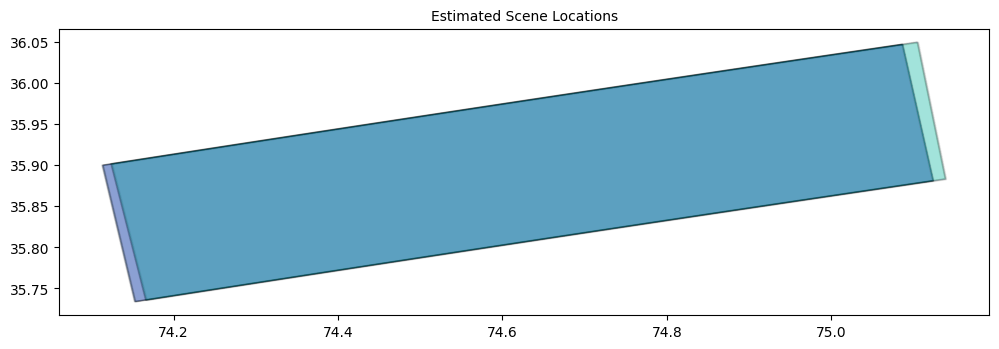

In [ ]:
sbas.plot_scenes()

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

In [ ]:
# # define the area of interest (AOI) to speedup the processing
# sbas.load_dem(DEM, AOI)

INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:54676; closing.
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:38669'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45161'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35187'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35931'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:54644; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:54630; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:54658; closing.
INFO:distributed.core:Received 'clos

<Client: 'inproc://172.28.0.12/627/1' processes=1 threads=4, memory=167.05 GiB>


Tiles Parallel Downloading:   0%|          | 0/4 [00:00<?, ?it/s]

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

DEM ready: /content/raw_imperial/DEM_WGS84.nc


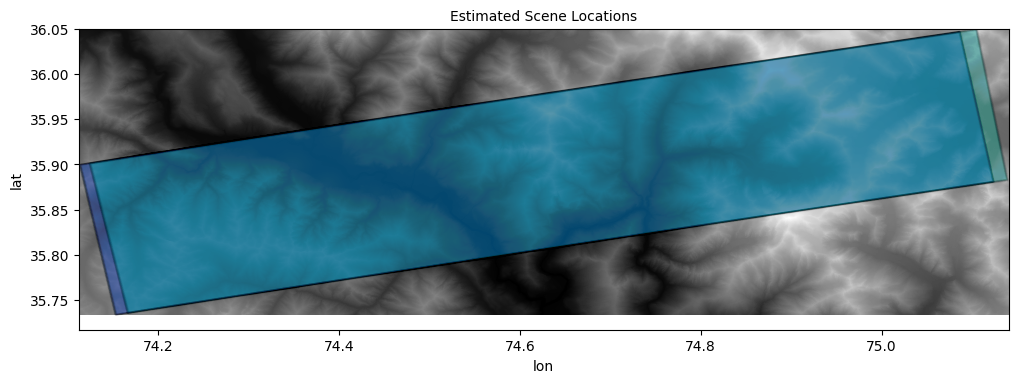

In [ ]:
# --- robust DEM (Colab) ---
import os, matplotlib.pyplot as plt
from pathlib import Path
from dask.distributed import Client

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"   # avoid HDF5 lock issues

# close any old client
try: client.close()
except: pass
plt.close('all')

WORKDIR = "raw_imperial"
DATADIR = "data_imperial"
DEM_RAW   = Path(WORKDIR) / "DEM_tiles.nc"
DEM_WGS84 = Path(WORKDIR) / "DEM_WGS84.nc"

# make sure we have a stack and scenes set already:
# sbas = Stack(WORKDIR).set_scenes(S1.scan_slc(DATADIR)).set_reference(REFERENCE)

# clear stale DEM
sbas.set_dem(None)
for p in (DEM_RAW, DEM_WGS84):
    p.unlink(missing_ok=True)

# AOI from your SLCs
AOI = S1.scan_slc(DATADIR)

# >>> start a local Dask client BEFORE load_dem <<<
client = Client(processes=False, n_workers=1, threads_per_worker=4)
print(client)

# download DEM to a file (uses cached tiles if available)
Tiles().download_dem(AOI, filename=str(DEM_RAW))

# let PyGMTSAR create the grid & convert to ellipsoid; this writes DEM_WGS84.nc
sbas.load_dem(str(DEM_RAW), AOI)

assert DEM_WGS84.exists(), "DEM_WGS84.nc was not created"
print("DEM ready:", DEM_WGS84.resolve())

# quick sanity check
sbas.plot_scenes()
plt.savefig('Estimated Scene Locations.jpg', dpi=180)
plt.savefig(os.path.join(base_path, 'Estimated Scene Locations on DEM.jpg'))


In [ ]:
# sbas.plot_scenes()
# plt.savefig('Estimated Scene Locations.jpg')

## Align a Stack of Images

In [ ]:
sbas.compute_align()

Preparing Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/92 [00:00<?, ?it/s]

## SBAS Baseline

In [ ]:
baseline_pairs = sbas.baseline_pairs(days=BASEDAYS, meters=BASEMETERS)
baseline_pairs.to_csv(os.path.join(base_path,'baseline_pairs.csv'),index=False)
baseline_pairs

Note: function baseline_pairs() renamed to sbas_pairs(). Use separate filtering functions when needed.


,ref,rep,ref_baseline,rep_baseline,pair,baseline,duration,rel
0,2018-03-08,2018-03-20,26.30,44.87,2018-03-08 2018-03-20,18.57,12,NaT
1,2018-03-08,2018-04-01,26.30,47.04,2018-03-08 2018-04-01,20.74,24,NaT
2,2018-03-08,2018-04-13,26.30,-32.31,2018-03-08 2018-04-13,-58.61,36,NaT
3,2018-03-20,2018-04-01,44.87,47.04,2018-03-20 2018-04-01,2.17,12,NaT
4,2018-03-20,2018-04-13,44.87,-32.31,2018-03-20 2018-04-13,-77.18,24,NaT
...,...,...,...,...,...,...,...,...
212,2021-02-20,2021-03-16,9.75,38.35,2021-02-20 2021-03-16,28.60,24,NaT
213,2021-02-20,2021-03-28,9.75,26.33,2021-02-20 2021-03-28,16.58,36,NaT
214,2021-03-04,2021-03-16,25.14,38.35,2021-03-04 2021-03-16,13.21,12,NaT
215,2021-03-04,2021-03-28,25.14,26.33,2021-03-04 2021-03-28,1.19,24,NaT


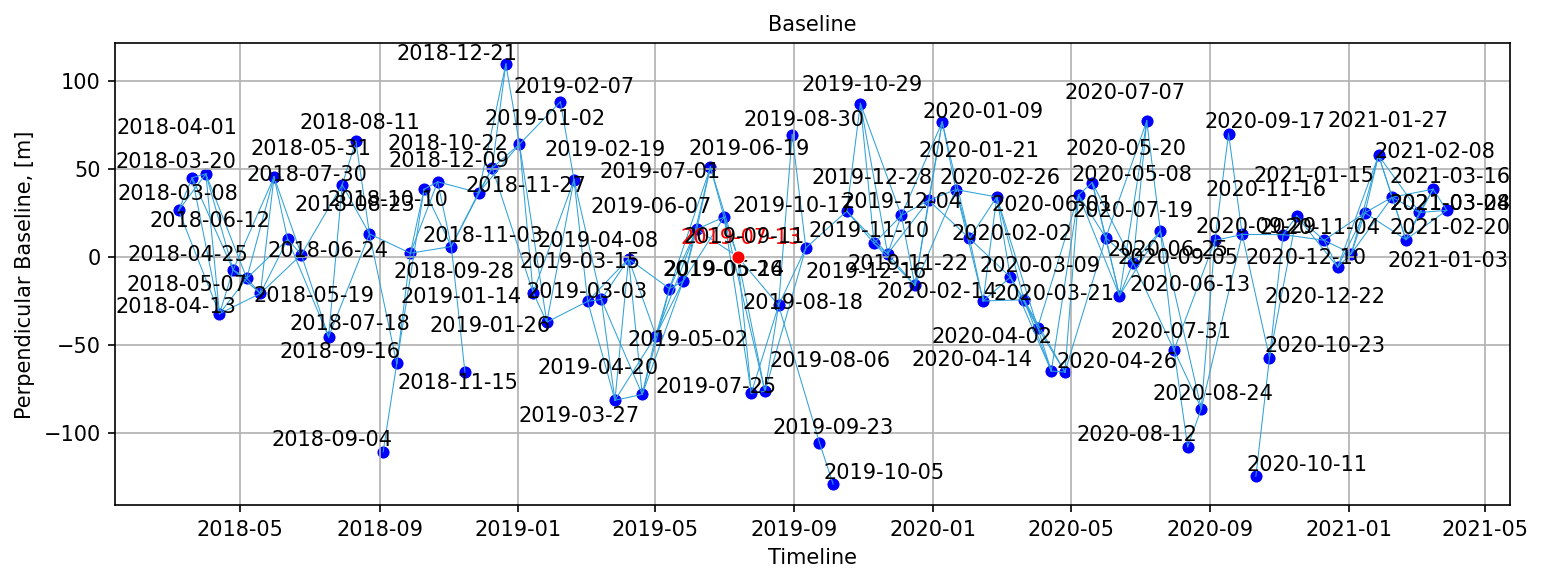

In [ ]:
with mpl_settings({'figure.dpi': 150}):
    sbas.plot_baseline(baseline_pairs)
plt.savefig('Baseline.jpg')
plt.savefig(os.path.join(base_path,'Baseline.jpg'))

## Geocoding

In [ ]:
# use default 60m coordinates grid
sbas.compute_geocode()

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

### DEM in Radar Coordinates

The grids are NetCDF files processing as xarray DataArrays.

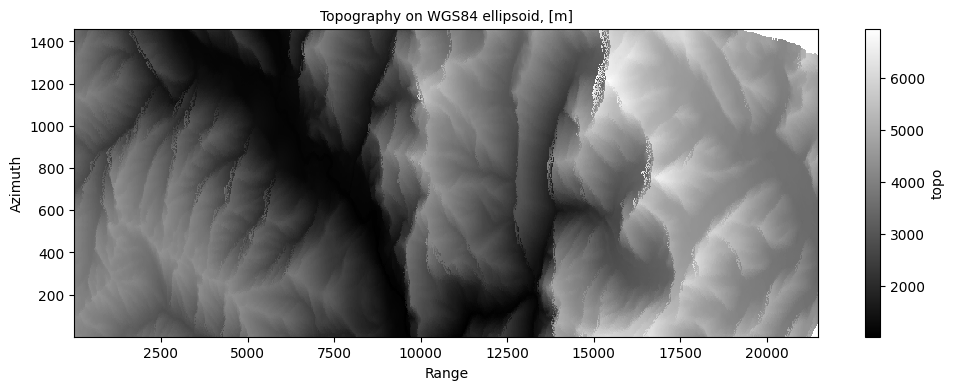

In [ ]:
sbas.plot_topo()
plt.savefig('Topography on WGS84 ellipsoid, [m].jpg')
plt.savefig(os.path.join(base_path,'Topography on WGS84 ellipsoid, [m].jpg'))

## Interferograms

Define a single interferogram or a SBAS series. Make direct and reverse interferograms (from past to future or from future to past).

Decimation is useful to save disk space. Geocoding results are always produced on the provided DEM grid so the output grid and resolution are the same to the DEM. By this way, ascending and descending orbit results are always defined on the same grid by design. An internal processing cell is about 30 x 30 meters size and for default output 60m resolution (like to GMTSAR and GAMMA software) decimation 2x2 is reasonable. For the default wavelength=200 for Gaussian filter 1/4 of wavelength is approximately equal to ~60 meters and better resolution is mostly useless (while it can be used for small objects detection). For wavelength=400 meters use 90m DEM resolution with decimation 4x4.

The grids are NetCDF files processing as xarray DataArrays.

In [ ]:
pairs = baseline_pairs[['ref', 'rep']]
pairs.to_csv(os.path.join(base_path,'pairs.csv'),index=False)
pairs

,ref,rep
0,2018-03-08,2018-03-20
1,2018-03-08,2018-04-01
2,2018-03-08,2018-04-13
3,2018-03-20,2018-04-01
4,2018-03-20,2018-04-13
...,...,...
212,2021-02-20,2021-03-16
213,2021-02-20,2021-03-28
214,2021-03-04,2021-03-16
215,2021-03-04,2021-03-28


In [ ]:
# ===== REPLACEMENT FOR BLOCK 17 (lazy & memory-safe) =====
import dask, numpy as np, gc

# 1) Open data lazily
data = sbas.open_data()  # VV amplitude/phase (lazy dask array)

# 2) Multilook BEFORE decimation (Alexey-style settings for 60 m output)
WAVEL   = 200            # anti-alias Gaussian cutoff in meters (for plain areas keep higher 400 or 500) and ram also depends
COARSEN = (2, 4)         # azimuth x range looks (for plain areas 1,2)
phase_ml = sbas.multilooking(sbas.phasediff(pairs), wavelength=WAVEL, coarsen=COARSEN)
inten_ml = sbas.multilooking(np.square(np.abs(data)),     wavelength=WAVEL, coarsen=COARSEN)
corr_ml  = sbas.correlation(phase_ml, inten_ml)

# 3) Decimate to 60 m (keep it LAZY)
decimator = sbas.decimator()   # default ~60 m grid
corr60m_lazy  = decimator(corr_ml)
phase60m_lazy = decimator(phase_ml)

# 4) Goldstein filter on the lazy 60 m phase, still LAZY
intf60m_lazy = sbas.interferogram(sbas.goldstein(phase60m_lazy, corr60m_lazy, 32))

# 5) NOW compute results together (lower peak RAM) and keep expected names
corr60m, intf60m = dask.compute(corr60m_lazy, intf60m_lazy)

# 6) Cleanup
del data, phase_ml, inten_ml, corr_ml, corr60m_lazy, phase60m_lazy, intf60m_lazy
gc.collect()
# ===== END REPLACEMENT =====


5970

In [ ]:
# ===== Block 17.1 : pair-level QC & pruning (label-safe) =====
import xarray as xr, pandas as pd

# Either lower this number to get more images to
CORR_MASK_T  = 0.33 #0.33
PAIR_MIN_COV = 0.30 #.30
PAIR_MIN_MED = 0.30 #0.30

# Option-A
# # new (looser QC → more pairs survive)
# CORR_MASK_T  = 0.18
# PAIR_MIN_COV = 0.10
# PAIR_MIN_MED = 0.18

# pixel-level mask on the 60 m grid
mask60m = (corr60m >= CORR_MASK_T)

# per-pair stats (index is the xarray 'pair' coordinate: strings like "2018-06-12 2018-06-24")
pair_cov = mask60m.mean(("y","x")).to_series()
pair_med = corr60m.median(("y","x")).to_series()

# # Option-C (to keep a specific number)
# TARGET = 35  # desired max number of interferograms to show
# # rank by coverage + median coherence (lower score = better)
# rank = pair_cov.rank(ascending=False) + pair_med.rank(ascending=False)
# order = rank.sort_values().index
# keep_labels = order[:TARGET]


# labels of pairs to keep
# keep_labels = pair_cov[(pair_cov >= PAIR_MIN_COV) & (pair_med >= PAIR_MIN_MED)].index.values

# Option B: keep ALL pairs produced by the baseline step
keep_labels = corr60m["pair"].values #this keeps all the images in the list ignores masking in A


# --- align DF index with xarray 'pair' labels, then select by label ---
pairs = pairs.copy()
pairs["pair"] = corr60m["pair"].values        # attach the same labels used by xarray
pairs = pairs.set_index("pair")               # index becomes pair labels

# subset everything using labels (not integer positions)
pairs   = pairs.loc[keep_labels].reset_index(drop=True)
corr60m = corr60m.sel(pair=keep_labels)
intf60m = intf60m.sel(pair=keep_labels)
mask60m = mask60m.sel(pair=keep_labels)

# (optional) save which pairs survived
pairs.to_csv(os.path.join(base_path, "pairs_pruned.csv"), index=False)
print(f"Pairs kept after QC: {corr60m.sizes.get('pair', len(keep_labels))}")
# ===== END Block 17.1 =====


Pairs kept after QC: 217


In [ ]:
# --- Block 17.1b: slope mask from DEM_WGS84.nc (dask-safe) ---
import xarray as xr, numpy as np, dask
from pathlib import Path

DEM_WGS84 = Path(WORKDIR) / "DEM_WGS84.nc"
ds = xr.open_dataset(DEM_WGS84, chunks="auto")

# pick the largest 2D/3D var as DEM
cands = []
for k, v in ds.data_vars.items():
    if v.ndim >= 2:
        size2 = int(np.prod([v.sizes[d] for d in v.dims[-2:]]))
        cands.append((k, size2))
assert cands, "No 2D-like variable found in DEM_WGS84.nc"
dem_name = sorted(cands, key=lambda t: t[1], reverse=True)[0][0]
dem = ds[dem_name]

# squeeze singleton band if present
for b in ("band","bands","b","layer","lvl","time"):
    if b in dem.dims and dem.sizes[b] == 1:
        dem = dem.isel({b: 0}, drop=True)

# rename dims to y/x if needed
dim_map = {}
for d in dem.dims:
    dl = d.lower()
    if dl in ("y","row","rows","northing") or dl.startswith("y") or dl.startswith("lat"):
        dim_map[d] = "y"
    elif dl in ("x","col","cols","column","easting") or dl.startswith("x") or dl.startswith("lon"):
        dim_map[d] = "x"
dem = dem.rename(dim_map)
assert set(("y","x")).issubset(set(dem.dims)), f"DEM dims {dem.dims} lack y/x"

# dask-friendly gradients (meters per meter)
dZdy = dem.differentiate("y")
dZdx = dem.differentiate("x")

# slope in degrees (parallelized over dask)
slope_deg = xr.apply_ufunc(
    lambda a,b: np.degrees(np.arctan(np.hypot(a,b))),
    dZdy, dZdx,
    dask="parallelized",
    output_dtypes=[np.float32]
)

# decimate to 60 m to match corr60m/intf60m
decimator = sbas.decimator()
slope60m = dask.compute(decimator(slope_deg))[0]

SLOPE_MAX = 38
final_mask = (corr60m >= 0.33) & (slope60m <= SLOPE_MAX)
print(f"Slope mask ready from var '{dem_name}'.")


Slope mask ready from var 'dem'.


In [ ]:
# --- Align slope to corr grid, build weight, unwrap ---
import xarray as xr
import numpy as np
import dask

CORR_T    = 0.33
SLOPE_MAX = 38

# 1) Make a 2D reference grid from corr60m
ref2d = corr60m.isel(pair=0)          # dims: ('y','x')

# 2) Align slope60m to that grid
#    Interpolate/reindex so y/x coords match corr60m's grid exactly
slope60m_aligned = slope60m.interp_like(ref2d, method="nearest")

# 3) Build boolean mask with aligned slope
mask = (corr60m >= CORR_T) & (slope60m_aligned <= SLOPE_MAX)

# 4) Numeric weight aligned to intf60m
weight = corr60m.where(mask, other=0.0).astype("float32")
weight = weight.broadcast_like(intf60m)           # ensure coords/dims match
weight = weight.transpose(*intf60m.dims)          # enforce identical dim order

# sanity check
print("intf60m:", intf60m.shape, intf60m.dims)
print("weight :", weight.shape , weight.dims)
assert intf60m.shape == weight.shape

# 5) Unwrap
unwrap = dask.compute(sbas.unwrap_snaphu(intf60m, weight))[0]
print("Unwrapping done.")


intf60m: (217, 181, 1342) ('pair', 'y', 'x')
weight : (217, 181, 1342) ('pair', 'y', 'x')
Unwrapping done.


In [ ]:
# After Block 17 (you have corr60m, intf60m)
sbas.plot_interferograms(intf60m, cols=6, size=2.2, caption='Phase, [rad]')
plt.savefig(os.path.join(base_path, 'Phase_before_QC.jpg'), dpi=150)

sbas.plot_correlations(corr60m, cols=6, size=2.2, caption='Correlation')
plt.savefig(os.path.join(base_path, 'Correlation_before_QC.jpg'), dpi=150)


## Unwrapping

Unwrapping process requires a lot of RAM and that's really RAM consuming when a lot of parallel proccesses running togeter. To limit the parallel processing tasks apply argument "n_jobs". The default value n_jobs=-1 means all the processor cores van be used. Also, use interferogram decimation above to produce smaller interferograms. And in addition a custom SNAPHU configuration can reduce RAM usage as explained below.

Attention: in case of crash on MacOS Apple Silicon run Jupyter as

`OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES no_proxy='*' jupyter notebook`

In [ ]:
sbas.plot_phases(unwrap.phase, cols=6, size=2.5, caption='Unwrapped Phase, [rad]', quantile=[0.01, 0.99])
plt.savefig('Unwrapped Phase, [rad].jpg')
plt.savefig(os.path.join(base_path, 'Unwrapped Phase, [rad].jpg'))

In [ ]:
# Rebuild a slope-aware mask aligned to corr60m
import xarray as xr

CORR_T    = 0.33
SLOPE_MAX = 38

# reference 2D grid from corr60m
ref2d = corr60m.isel(pair=0)

# align slope to corr grid exactly
slope60m_aligned = slope60m.interp_like(ref2d, method="nearest")
# copy coords so labels match 1:1
slope60m_aligned = slope60m_aligned.assign_coords(y=ref2d["y"], x=ref2d["x"])

# boolean mask with implicit broadcast over 'pair'
mask_aligned = (corr60m >= CORR_T) & (slope60m_aligned <= SLOPE_MAX)
# enforce identical dim order
mask_aligned = mask_aligned.transpose(*corr60m.dims)

# numeric weights in [0,1]
weights = xr.where(mask_aligned, corr60m, 0.0).astype("float32")
print("weights:", weights.shape, weights.dims)


weights: (217, 181, 1342) ('pair', 'y', 'x')


In [ ]:
# Weighted planar ramp removal per pair
import numpy as np
import xarray as xr

phase = unwrap.phase
K, NY, NX = phase.shape

# coordinate grids (meters), centered to stabilize the fit
y = phase["y"].values.astype(np.float64)
x = phase["x"].values.astype(np.float64)
Y, X = np.meshgrid(y - y.mean(), x - x.mean(), indexing="ij")
ONES = np.ones_like(X)

detrend_arr = np.empty_like(phase.values, dtype=np.float32)

for k in range(K):
    z = phase.isel(pair=k).values.astype(np.float64)
    w = weights.isel(pair=k).values.astype(np.float64)

    valid = np.isfinite(z) & (w > 0)
    if valid.sum() < 200:
        detrend_arr[k] = z.astype(np.float32)
        continue

    # build weighted system for plane: beta0 + beta1*X + beta2*Y
    A  = np.stack([ONES[valid], X[valid], Y[valid]], axis=1)  # N x 3
    ww = w[valid]
    Aw = A * ww[:, None]
    zw = z[valid] * ww

    beta, *_ = np.linalg.lstsq(Aw, zw, rcond=None)  # 3,
    ramp = beta[0]*ONES + beta[1]*X + beta[2]*Y
    detrend_arr[k] = (z - ramp).astype(np.float32)

detrend = xr.DataArray(
    detrend_arr, dims=phase.dims, coords=phase.coords, name="phase_detrended"
)

# # Plots
# sbas.plot_phases(detrend, cols=3, size=3,
#                  caption="Detrended Unwrapped Phase, [rad]",
#                  quantile=[0.01, 0.99])
# plt.savefig("Detrended Unwrapped Phase, [rad].jpg", dpi=150)
# plt.savefig(os.path.join(base_path, "Detrended Unwrapped Phase, [rad].jpg"), dpi=150)

# # optional AOI
# detrend_subset = detrend.sel(x=slice(0, 26000), y=slice(0, 1500))
# sbas.plot_phases(detrend_subset, cols=3, size=3,
#                  caption="Detrended Unwrapped Phase AOI, [rad]",
#                  quantile=[0.01, 0.99])
# plt.savefig("Detrended Unwrapped Phase AOI, [rad].jpg", dpi=150)
# plt.savefig(os.path.join(base_path, "Detrended Unwrapped Phase AOI, [rad].jpg"), dpi=150)


In [ ]:
# === Block 22C: Pretty, wide plots like your "Unwrapped Phase, [rad]" ===
with mpl_settings({'figure.dpi': 150, 'figure.titlesize': 15}):
    # full stack, wide (6 cols), same quantile scaling as before
    sbas.plot_phases(
        detrend,
        cols=6,           # <- wide grid like before
        size=2.2,         # <- matches earlier cell size
        caption='Detrended Unwrapped Phase, [rad]',
        quantile=[0.01, 0.99]
    )
plt.savefig('Detrended Unwrapped Phase, [rad]_wide.jpg', dpi=180)
plt.savefig(os.path.join(base_path, 'Detrended Unwrapped Phase, [rad]_wide.jpg'), dpi=180)

# # Optional: AOI preview, still wide
# detrend_subset = detrend.sel(x=slice(0, 26000), y=slice(0, 1500))
# with mpl_settings({'figure.dpi': 150, 'figure.titlesize': 15}):
#     sbas.plot_phases(
#         detrend_subset,
#         cols=6,
#         size=2.2,
#         caption='Detrended Unwrapped Phase AOI, [rad]',
#         quantile=[0.01, 0.99]
#     )
# plt.savefig('Detrended Unwrapped Phase AOI, [rad]_wide.jpg', dpi=180)
# plt.savefig(os.path.join(base_path, 'Detrended Unwrapped Phase AOI, [rad]_wide.jpg'), dpi=180)


In [ ]:
# ===== Robust Block 23A: diagnose -> auto-relax -> WLS solve =====
import numpy as np, xarray as xr
from pygmtsar import tqdm_dask

# Use detrended phase if available; otherwise, the raw unwrapped phase
phase_in = detrend if 'detrend' in globals() else unwrap.phase

# Helper: build weights from coherence and (optional) slope
def make_weights(corr_da, slope_da_or_none, corr_t, slope_max):
    ref2d = corr_da.isel(pair=0)  # ('y','x') grid for alignment
    if (slope_da_or_none is not None) and (slope_max is not None):
        slope_a = slope_da_or_none.interp_like(ref2d, method="nearest")
        mask = (corr_da >= corr_t) & (slope_a <= slope_max)
    else:
        mask = (corr_da >= corr_t)
    w = corr_da.where(mask, other=0.0).astype("float32")
    # match dims/order of interferograms
    return w.broadcast_like(intf60m).transpose(*intf60m.dims)

# Try progressively looser thresholds until coverage is reasonable
tries = [
    (0.33, 38),
    (0.30, 42),
    (0.27, 45),
    (0.24, 48),
    (0.20, 50),
    (0.18, None),   # ignore slope if still too strict
]

slope_src = slope60m if 'slope60m' in globals() else None
weights, picked = None, None
for corr_t, smax in tries:
    w   = make_weights(corr60m, slope_src, corr_t, smax)
    cov = (w > 0).mean(("y","x")).compute().values     # per-pair fraction
    mean_cov = float(np.nanmean(cov))
    print(f"try corr≥{corr_t}, slope≤{smax}: mean coverage={mean_cov:.3f}")
    if mean_cov >= 0.02 or (mean_cov > 0 and picked is None):  # accept once we have some support
        weights, picked = w, (corr_t, smax, mean_cov)
        if mean_cov >= 0.02:
            break

# Absolute fallback: tiny weights where coherence exists (just to avoid the "all zero" case)
if weights is None:
    w = xr.where(np.isfinite(corr60m), xr.where(corr60m > 0, corr60m, 0.1), 0.0).astype("float32")
    weights = w.broadcast_like(intf60m).transpose(*intf60m.dims)
    picked  = ("fallback", None, float((weights > 0).mean(("y","x")).compute()))
print("Using thresholds:", picked)

# Simple phase range sanity (as scalars; avoids the earlier MergeError)
p_lo = phase_in.quantile(0.01, ("y","x")).compute().min().item()
p_hi = phase_in.quantile(0.99, ("y","x")).compute().max().item()
print(f"Phase 1–99% across pairs: {p_lo:.2f} … {p_hi:.2f} rad")

# ---- Weighted least-squares SBAS (same method) ----
tqdm_dask(disp := sbas.los_displacement_mm(sbas.lstsq(phase_in, weights)).persist(),
          desc='SBAS (WLS)')

# The first epoch is zero by construction; hide it for plotting scale
disp = disp.copy()
disp[0] = np.nan

with mpl_settings({'figure.dpi': 150, 'figure.titlesize': 36}):
    sbas.plot_displacements(disp, cols=3, size=3,
                            caption='Cumulative LOS Displacement, [mm]',
                            quantile=[0.01, 0.99])
plt.savefig('Cumulative LOS Displacement, [mm].jpg', dpi=180)
plt.savefig(os.path.join(base_path, 'Cumulative LOS Displacement, [mm].jpg'), dpi=180)

# keep a handy AOI subset
disp_subset = disp.sel(x=slice(0, 26000), y=slice(0, 1500))
# ===== END Block 23A =====


In [ ]:
# ===== Block 23A→23C GLUE: make los_mm (and optional los_geo) from disp =====
import numpy as np, pandas as pd, xarray as xr, dask

# 1) promote disp -> los_mm (keep first epoch NaN exactly as you set above)
los_mm = disp.rename("los_mm").astype("float32")

# 2) normalize time dimension name to 'date' (plotter accepts any name, but this keeps it tidy)
t_dim = [d for d in los_mm.dims if d not in ("y", "x")][0]
if t_dim != "date":
    los_mm = los_mm.rename({t_dim: "date"})

# 3) if the time coord isn’t datetime64, try to attach real dates (optional, for nicer labels)
try:
    if not np.issubdtype(los_mm["date"].dtype, np.datetime64):
        # sbas.to_dataframe() usually has an epoch list
        df = sbas.to_dataframe()
        if "date" in df.columns:
            dates = pd.to_datetime(sorted(df["date"].unique()))
            if len(dates) == los_mm.sizes["date"]:
                los_mm = los_mm.assign_coords(date=dates)
except Exception:
    pass

print("Final los_mm dims:", los_mm.dims, los_mm.shape)
try:
    lo = float(los_mm.min(skipna=True).compute()); hi = float(los_mm.max(skipna=True).compute())
except Exception:
    lo = float(los_mm.min(skipna=True)); hi = float(los_mm.max(skipna=True))
print(f"los_mm range [mm]: {lo:.2f} .. {hi:.2f}")

# 4) OPTIONAL: geocode the full stack for the geo mosaic; skip cleanly if transforms are messy
try:
    los_geo = dask.compute(sbas.ra2ll(los_mm))[0]
    print("los_geo:", los_geo.dims, tuple(los_geo.shape))
except Exception as e:
    print("Geo skipped:", e)
    if "los_geo" in globals():
        del los_geo
# ===== End GLUE =====


Final los_mm dims: ('date', 'y', 'x') (92, 181, 1342)
los_mm range [mm]: -723.58 .. 1483.44
los_geo: ('date', 'lat', 'lon') (92, 309, 1339)


In [ ]:
# Just added
# ===== Block 5.1: Publishable stack (stable-area reference + sign) =====
import numpy as np, xarray as xr, dask

# SIGN: +1 => "+ means TOWARD satellite"; set to -1 if you want the opposite.
SIGN = +1

# Ensure slope is aligned to corr grid (if not already from Block 1)
if "slope60m_aligned" not in globals():
    ref2d = corr60m.isel(pair=0)
    slope60m_aligned = slope60m.interp_like(ref2d, method="nearest") \
                                   .assign_coords(y=ref2d["y"], x=ref2d["x"])

# build a stable mask for referencing; start strict and relax if needed
coh_med = corr60m.median("pair")
tries = [(0.35,25), (0.33,30), (0.30,35), (0.30,40)]
stable_mask_ref = None
for ct, st in tries:
    m = (coh_med > ct) & (slope60m_aligned <= st)
    cov = float(m.mean().compute())
    if cov >= 0.01:  # need at least ~1% area
        print(f"[ref] using COH_T={ct}, SLOPE_T={st} (coverage~{cov*100:.1f}%)")
        stable_mask_ref = m
        break
if stable_mask_ref is None:
    stable_mask_ref = (coh_med > 0.20)  # last-resort, ignore slope
    print("[ref] fallback COH_T=0.20 (slope ignored).")

# per-epoch median removal over the stable area
ref_curve   = los_mm.where(stable_mask_ref).median(("y","x"))
los_mm_pub  = SIGN * (los_mm - ref_curve)
los_mm_pub  = los_mm_pub.rename("los_mm_pub").astype("float32")
print("Publishable stack ready:", los_mm_pub.dims, los_mm_pub.shape)

# Geocode once so we reuse it later
try:
    los_geo_pub = dask.compute(sbas.ra2ll(los_mm_pub))[0]
except Exception as e:
    print("Geo publishable stack skipped:", e)


[ref] fallback COH_T=0.20 (slope ignored).
Publishable stack ready: ('date', 'y', 'x') (92, 181, 1342)


ERROR:distributed.worker:Compute Failed
Key:       ('from-value-getitem-intf_block-concatenate-0a727fc46f958f8f2674e5832c1e189f', 34, 0, 0)
State:     long-running
Task:  <Task ('from-value-getitem-intf_block-concatenate-0a727fc46f958f8f2674e5832c1e189f', 34, 0, 0) _execute_subgraph(...)>
Exception: "InvalidIndexError('Reindexing only valid with uniquely valued Index objects')"
Traceback: '  File "/usr/local/lib/python3.12/dist-packages/pygmtsar/Stack_geocode.py", line 200, in intf_block\n    trans_block = trans.sel(lat=lats_block, lon=lons_block).compute(n_workers=1)\n                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 2974, in sel\n    query_results = map_index_queries(\n                    ^^^^^^^^^^^^^^^^^^\n  File "/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py", line 201, in map_index_queries\n    results.append(index.sel(labels, **options))\n                   ^^^^^^^^^^^^^^^^

Geo publishable stack skipped: Reindexing only valid with uniquely valued Index objects


In [ ]:
# # ===== Block 23B: geocode AOI result (will skip gracefully if transform missing) =====
# do_geo = True
# try:
#     disp_subset_ll = dask.compute(sbas.cropna(sbas.ra2ll(disp_subset)))[0]
# except Exception as e:
#     print("Geocoding failed; continuing without geographic plots.\nReason:", repr(e))
#     do_geo = False

# if do_geo:
#     with mpl_settings({'figure.dpi': 150, 'figure.titlesize': 30}):
#         sbas.plot_displacements(disp_subset_ll, cols=3, size=3,
#                                 caption='Cumulative LOS Displacement (Geo) AOI, [mm]',
#                                 quantile=[0.01, 0.99])
#     plt.savefig('Cumulative LOS Displacement Geographic Coordinates AOI, [mm].jpg', dpi=180)
#     plt.savefig(os.path.join(base_path, 'Cumulative LOS Displacement Geographic Coordinates AOI, [mm].jpg'), dpi=180)


# ===== Replace Block 23B with this =====
# Make an AOI mosaic directly from geocoded PUBLISHABLE stack
try:
    _time_dim = [d for d in los_geo_pub.dims if d not in ("lat","lon")][0]
    # (optional) crop to a smaller geographic box for the figure, if desired:
    # los_geo_pub_aoi = los_geo_pub.sel(lat=slice(35.75, 36.05), lon=slice(74.2, 75.1))
    los_geo_pub_aoi = los_geo_pub  # full swath

    with mpl_settings({'figure.dpi': 150, 'figure.titlesize': 30}):
        sbas.plot_displacements(los_geo_pub_aoi, cols=3, size=3,
                                caption='Cumulative LOS Displacement (Geo, publishable), [mm]',
                                quantile=[0.01, 0.99])
    plt.savefig('Cumulative LOS Displacement Geographic Coordinates AOI, [mm].jpg', dpi=180)
    plt.savefig(os.path.join(base_path, 'Cumulative LOS Displacement Geographic Coordinates AOI, [mm].jpg'), dpi=180)
except Exception as e:
    print("Geo AOI plot skipped:", e)
# ===== end replacement =====



Geo AOI plot skipped: name 'los_geo_pub' is not defined


In [ ]:
# # ===== Wide mosaic plotters for LOS displacement (radar + geo) =====
# import os
# import numpy as np
# import pandas as pd
# import xarray as xr
# import matplotlib.pyplot as plt
# from math import ceil

# # ---------- small helpers ----------
# def _time_dim(da: xr.DataArray) -> str:
#     """Return the name of the time dimension (anything not lat/lon/x/y)."""
#     for d in da.dims:
#         if d not in ("y", "x", "lat", "lon", "latitude", "longitude"):
#             return d
#     raise ValueError("Could not find a time-like dimension in DataArray.")

# def _labels_from_coord(da: xr.DataArray, time_dim: str) -> list[str]:
#     """Pretty labels from the time coordinate; falls back to raw values."""
#     coord = da[time_dim]
#     try:
#         if np.issubdtype(coord.dtype, np.datetime64):
#             return pd.to_datetime(coord.values).strftime("%Y-%m-%d").tolist()
#     except Exception:
#         pass
#     return [str(v) for v in coord.values]

# def _global_range(da: xr.DataArray, q=(0.01, 0.99)) -> tuple[float, float]:
#     """Robust global vmin/vmax using quantiles across all dims."""
#     qq = da.quantile(q)
#     # works with dask-backed arrays too
#     vmin = float(qq.sel(quantile=q[0]).values)
#     vmax = float(qq.sel(quantile=q[1]).values)
#     # guard against identical min/max
#     if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
#         vmin, vmax = float(da.min()), float(da.max())
#     return vmin, vmax

# # ---------- plotting functions ----------
# def plot_wide_panels_radar(
#     da: xr.DataArray,
#     labels: list[str] | None = None,
#     title: str = "",
#     outfile: str | None = None,
#     max_cols: int = 6,
# ):
#     """Wide mosaic on radar grid (dims: time, y, x)."""
#     tdim = _time_dim(da)
#     n = da.sizes[tdim]
#     cols = min(max_cols, max(1, n))
#     rows = ceil(n / cols)
#     if labels is None:
#         labels = _labels_from_coord(da, tdim)

#     vmin, vmax = _global_range(da, q=(0.01, 0.99))

#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.0, rows * 3.2), squeeze=False)
#     fig.suptitle(title, fontsize=28, weight="bold")

#     im = None
#     for i in range(rows * cols):
#         ax = axes[i // cols][i % cols]
#         if i < n:
#             d2 = da.isel({tdim: i})
#             im = ax.imshow(d2, origin="lower", vmin=vmin, vmax=vmax, cmap="turbo", aspect="auto")
#             ax.set_title(f"date = {labels[i]}", fontsize=11)
#             ax.set_xlabel("Range")
#             ax.set_ylabel("Azimuth")
#         else:
#             ax.axis("off")

#     # reserve space for colorbar on the right and place it there
#     fig.tight_layout(rect=[0, 0, 0.92, 0.95])  # leave 8% width for the colorbar
#     if im is not None:
#         cax = fig.add_axes([0.935, 0.12, 0.012, 0.76])  # [left, bottom, width, height] in figure coords
#         cbar = fig.colorbar(im, cax=cax)
#         cbar.set_label("los [mm]")

#     if outfile:
#         fig.savefig(outfile, dpi=200, facecolor="white")
#     plt.show()

# def plot_wide_panels_geo(
#     da: xr.DataArray,
#     labels: list[str] | None = None,
#     title: str = "",
#     outfile: str | None = None,
#     max_cols: int = 6,
# ):
#     """Wide mosaic on geographic grid (dims: time, lat, lon)."""
#     tdim = _time_dim(da)
#     lat_name = "lat" if "lat" in da.dims else "latitude"
#     lon_name = "lon" if "lon" in da.dims else "longitude"

#     n = da.sizes[tdim]
#     cols = min(max_cols, max(1, n))
#     rows = ceil(n / cols)
#     if labels is None:
#         labels = _labels_from_coord(da, tdim)

#     vmin, vmax = _global_range(da, q=(0.01, 0.99))

#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.0, rows * 3.4), squeeze=False)
#     fig.suptitle(title, fontsize=28, weight="bold")

#     im = None
#     LON, LAT = da[lon_name], da[lat_name]  # 1D or 2D both ok with shading="auto"
#     for i in range(rows * cols):
#         ax = axes[i // cols][i % cols]
#         if i < n:
#             d2 = da.isel({tdim: i})
#             im = ax.pcolormesh(LON, LAT, d2, shading="auto", vmin=vmin, vmax=vmax, cmap="turbo")
#             ax.set_title(f"date = {labels[i]}", fontsize=11)
#             ax.set_xlabel("lon")
#             ax.set_ylabel("lat")
#         else:
#             ax.axis("off")

#     fig.tight_layout(rect=[0, 0, 0.92, 0.95])
#     if im is not None:
#         cax = fig.add_axes([0.935, 0.12, 0.012, 0.76])
#         cbar = fig.colorbar(im, cax=cax)
#         cbar.set_label("los [mm]")

#     if outfile:
#         fig.savefig(outfile, dpi=200, facecolor="white")
#     plt.show()

# # ---------- run both plotters ----------
# # Assumes you already have: los_mm (radar grid, dims like ('date','y','x') or ('pair','y','x'))
# # Optionally los_geo (geo grid, dims like ('date','lat','lon') or ('pair','lat','lon'))
# # and base_path defined.

# time_dim_mm = _time_dim(los_mm)
# labels_mm   = _labels_from_coord(los_mm, time_dim_mm)

# plot_wide_panels_radar(
#     los_mm,
#     labels=labels_mm,
#     title="Cumulative LOS Displacement, [mm]",
#     outfile=os.path.join(base_path, "Cumulative_LOS_Displacement_wide.jpg"),
#     max_cols=6,
# )

# # Geographic mosaic (only if available)
# try:
#     los_geo  # just to see if it exists
#     time_dim_geo = _time_dim(los_geo)
#     labels_geo = labels_mm if los_geo.sizes[time_dim_geo] == len(labels_mm) else _labels_from_coord(los_geo, time_dim_geo)

#     plot_wide_panels_geo(
#         los_geo,
#         labels=labels_geo,
#         title="Cumulative LOS Displacement (Geo) AOI, [mm]",
#         outfile=os.path.join(base_path, "Cumulative_LOS_Displacement_GEO_wide.jpg"),
#         max_cols=6,
#     )
# except NameError:
#     pass
# # ===== end =====


In [ ]:
# Just added previous commented out
# ===== Wide mosaic plotters for LOS displacement (radar + geo) =====
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from math import ceil

def _time_dim(da: xr.DataArray) -> str:
    for d in da.dims:
        if d not in ("y","x","lat","lon","latitude","longitude"):
            return d
    raise ValueError("Could not find a time-like dimension in DataArray.")

def _labels_from_coord(da: xr.DataArray, time_dim: str) -> list[str]:
    coord = da[time_dim]
    try:
        if np.issubdtype(coord.dtype, np.datetime64):
            return pd.to_datetime(coord.values).strftime("%Y-%m-%d").tolist()
    except Exception:
        pass
    return [str(v) for v in coord.values]

def _global_range(da: xr.DataArray, q=(0.01, 0.99)) -> tuple[float, float]:
    qq = da.quantile(q)
    vmin = float(qq.sel(quantile=q[0]).values)
    vmax = float(qq.sel(quantile=q[1]).values)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = float(da.min()), float(da.max())
    return vmin, vmax

def plot_wide_panels_radar(da: xr.DataArray, labels=None, title="", outfile=None, max_cols=6):
    tdim = _time_dim(da)
    n = da.sizes[tdim]
    cols = min(max_cols, max(1, n))
    rows = ceil(n / cols)
    if labels is None:
        labels = _labels_from_coord(da, tdim)
    vmin, vmax = _global_range(da, q=(0.01, 0.99))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5.0, rows*3.2), squeeze=False)
    fig.suptitle(title, fontsize=28, weight="bold")
    im = None
    for i in range(rows*cols):
        ax = axes[i//cols][i%cols]
        if i < n:
            d2 = da.isel({tdim:i})
            im = ax.imshow(d2, origin="lower", vmin=vmin, vmax=vmax, cmap="turbo", aspect="auto")
            ax.set_title(f"date = {labels[i]}", fontsize=11)
            ax.set_xlabel("Range"); ax.set_ylabel("Azimuth")
        else:
            ax.axis("off")
    fig.tight_layout(rect=[0,0,0.92,0.95])
    if im is not None:
        cax = fig.add_axes([0.935, 0.12, 0.012, 0.76])
        cbar = fig.colorbar(im, cax=cax); cbar.set_label("los [mm]")
    if outfile: fig.savefig(outfile, dpi=200, facecolor="white")
    plt.show()

def plot_wide_panels_geo(da: xr.DataArray, labels=None, title="", outfile=None, max_cols=6):
    tdim = _time_dim(da)
    lat_name = "lat" if "lat" in da.dims else "latitude"
    lon_name = "lon" if "lon" in da.dims else "longitude"
    n = da.sizes[tdim]
    cols = min(max_cols, max(1, n))
    rows = ceil(n / cols)
    if labels is None:
        labels = _labels_from_coord(da, tdim)
    vmin, vmax = _global_range(da, q=(0.01, 0.99))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5.0, rows*3.4), squeeze=False)
    fig.suptitle(title, fontsize=28, weight="bold")
    im = None; LON, LAT = da[lon_name], da[lat_name]
    for i in range(rows*cols):
        ax = axes[i//cols][i%cols]
        if i < n:
            d2 = da.isel({tdim:i})
            im = ax.pcolormesh(LON, LAT, d2, shading="auto", vmin=vmin, vmax=vmax, cmap="turbo")
            ax.set_title(f"date = {labels[i]}", fontsize=11)
            ax.set_xlabel("lon"); ax.set_ylabel("lat")
        else:
            ax.axis("off")
    fig.tight_layout(rect=[0,0,0.92,0.95])
    if im is not None:
        cax = fig.add_axes([0.935, 0.12, 0.012, 0.76])
        cbar = fig.colorbar(im, cax=cax); cbar.set_label("los [mm]")
    if outfile: fig.savefig(outfile, dpi=200, facecolor="white")
    plt.show()

# ---- plot the PUBLISHABLE stack ----
time_dim_mm = _time_dim(los_mm_pub)
labels_mm   = _labels_from_coord(los_mm_pub, time_dim_mm)

plot_wide_panels_radar(
    los_mm_pub,
    labels=labels_mm,
    title="Cumulative LOS Displacement (publishable), [mm]  (+=toward sat)",
    outfile=os.path.join(base_path, "Cumulative_LOS_Displacement_PUBLISHABLE_wide.jpg"),
    max_cols=6,
)

try:
    los_geo_pub
    time_dim_geo = _time_dim(los_geo_pub)
    labels_geo = labels_mm if los_geo_pub.sizes[time_dim_geo] == len(labels_mm) \
                 else _labels_from_coord(los_geo_pub, time_dim_geo)
    plot_wide_panels_geo(
        los_geo_pub,
        labels=labels_geo,
        title="Cumulative LOS Displacement (Geo, publishable), [mm]",
        outfile=os.path.join(base_path, "Cumulative_LOS_Displacement_GEO_PUBLISHABLE_wide.jpg"),
        max_cols=6,
    )
except NameError:
    pass


In [ ]:

# Block 8 removed — using los_mm_pub from Block 5.1 for all downstream products

# # ==== Sign + Referencing block ====
# import xarray as xr
# import numpy as np

# # 1) Build a stable mask on the radar grid (coherence + slope you already computed)
# coh_med = corr60m.median('pair')                 # (y,x)
# stable_mask = (coh_med > 0.35) & (slope60m_aligned <= 25)

# # 2) Reference each epoch by subtracting the robust scene median over the stable area
# #    (use median to resist outliers). This removes epoch-to-epoch common mode.
# def reference_stack(los_da, mask2d, grid=("y","x")):
#     ref = los_da.where(mask2d).median(dim=grid)  # 1D over time
#     return los_da - ref

# los_mm_ref = reference_stack(los_mm, stable_mask, grid=("y","x"))

# # 3) Optional: do the same for geocoded stack if you have it (project mask if needed).
# #    If you built los_geo from los_mm via ra2ll date-by-date, you can just re-run that step
# #    on los_mm_ref and call it los_geo_ref. Otherwise skip this.
# # los_geo_ref = (geocode los_mm_ref the same way you made los_geo)

# # 4) Flip sign so that positive means TOWARD satellite (uplift)
# los_mm_ref = -los_mm_ref
# # if you have geocoded:
# # los_geo_ref = -los_geo_ref

# print("Applied epoch referencing and sign flip (positive = toward satellite).")


[radar-mask] coverage ≈ 0.0%
[geo-fallback] stable coverage ≈ 10.5% (std-threshold=59.31 mm)
Per-epoch median in GEO after referencing (should be ~0):
2018-03-08           NaN
2018-03-20      0.000000
2018-04-01     17.670000
2018-04-13      5.430000
2018-04-25      0.000000
                 ...    
2021-02-08   -360.790009
2021-02-20   -339.440002
2021-03-04   -341.660004
2021-03-16   -337.350006
2021-03-28   -339.299988
Length: 92, dtype: float32


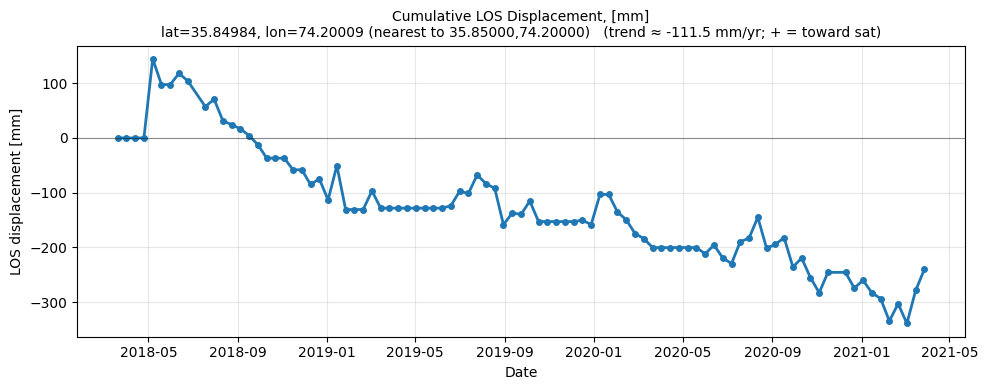

Saved: /content/drive/My Drive/all_new_analysis/ascending/S1_056057/POI_LOS_timeseries_REF_SIGNFIXED.jpg


In [ ]:
# ===== Block 24 (robust referencing + sign + POI plot, radar->geo fallback-safe) =====
import numpy as np, pandas as pd, xarray as xr, dask
import matplotlib.pyplot as plt, os

# ---------------- settings ----------------
TOWARD_POSITIVE = True   # True => + means TOWARD satellite
COH_T_RADAR     = 0.30   # start a bit looser than 0.35 for mountains
SLOPE_T_RADAR   = 40     # degrees
STABLE_Q_GEO    = 0.20   # fallback: lowest 20% temporal std considered stable

poi_lat, poi_lon = 35.85, 74.20
out_png = os.path.join(base_path, "POI_LOS_timeseries_REF_SIGNFIXED.jpg")

# ---------------- inputs we expect ----------------
assert 'los_mm' in globals(), "Need los_mm from Block 23A/23B"
los = los_mm  # dims: ('date','y','x') or ('pair','y','x')
time_dim = [d for d in los.dims if d not in ("y","x","lat","lon")][0]

# los_geo is handy and you created it earlier for the wide mosaics.
# If it's not present, try to compute very cautiously; otherwise skip geocoding to avoid the duplicate-index error.
if "los_geo" not in globals():
    los_geo = None
else:
    # Ensure coordinates are sorted (helps plotting/selection)
    if "lat" in los_geo.dims and "lon" in los_geo.dims:
        if not (np.all(np.diff(los_geo["lat"])>0) or np.all(np.diff(los_geo["lat"])<0)):
            los_geo = los_geo.sortby("lat")
        if not (np.all(np.diff(los_geo["lon"])>0) or np.all(np.diff(los_geo["lon"])<0)):
            los_geo = los_geo.sortby("lon")

# ---------------- TRY #1: radar-space coherence+slope mask ----------------
cov_radar = 0.0
try:
    coh_med = corr60m.median("pair")                 # (y,x)
    stable_radar = (coh_med > COH_T_RADAR)
    if "slope60m_aligned" in globals():
        stable_radar = stable_radar & (slope60m_aligned <= SLOPE_T_RADAR)
    cov_radar = float(stable_radar.mean().compute())
    print(f"[radar-mask] coverage ≈ {cov_radar*100:.1f}%")

    if cov_radar >= 0.01:
        # reference in radar space
        ref_curve = los.where(stable_radar).median(("y","x"))
        los_ref_radar = los - ref_curve

        # set sign convention
        if TOWARD_POSITIVE: los_ref_radar = -los_ref_radar

        # If geo stack exists, apply SAME epoch ref in geo space so POI is sampled safely
        if isinstance(los_geo, xr.DataArray):
            ref_curve_geo = los_geo.median(("lat","lon")) * 0  # placeholder to get dims
            # broadcast ref_curve to geo time axis
            ref_geo = xr.DataArray(ref_curve.values, coords={time_dim: los_geo[time_dim].values}, dims=(time_dim,))
            los_geo_ref = los_geo - ref_geo
            if TOWARD_POSITIVE: los_geo_ref = -los_geo_ref
        else:
            los_geo_ref = None
    else:
        los_ref_radar = None
        los_geo_ref = None
except Exception as e:
    print("[radar-mask] skipped due to error:", e)
    los_ref_radar = None
    los_geo_ref = None

# ---------------- TRY #2: geographic fallback via temporal stability ----------------
if los_geo_ref is None:
    assert isinstance(los_geo, xr.DataArray), (
        "Geo fallback needs 'los_geo'. If you don't have it in memory, re-run the wide-plot cell that computed it."
    )
    # temporal std per pixel -> take lowest STABLE_Q_GEO fraction as stable area
    tstd = los_geo.std(dim=time_dim, skipna=True)
    thr  = float(tstd.quantile(STABLE_Q_GEO))
    stable_geo = (tstd <= thr) & np.isfinite(tstd)
    cov_geo = float(stable_geo.mean().compute())
    print(f"[geo-fallback] stable coverage ≈ {cov_geo*100:.1f}% (std-threshold={thr:.2f} mm)")

    # epoch referencing in geographic space
    ref_curve_geo = los_geo.where(stable_geo).median(("lat","lon"))
    los_geo_ref = los_geo - ref_curve_geo

    if TOWARD_POSITIVE:
        los_geo_ref = -los_geo_ref

# ---------------- sanity print(s) ----------------
if los_geo_ref is not None:
    med_after = los_geo_ref.where(np.isfinite(los_geo_ref)).median(("lat","lon")).compute()
    print("Per-epoch median in GEO after referencing (should be ~0):")
    print(pd.Series(med_after.values, index=pd.to_datetime(los_geo_ref[time_dim].values)).round(2))

# ---------------- POI time series from GEO (no ra2ll here) ----------------
assert los_geo_ref is not None, "We still don't have a referenced geo stack. Stop here."

poi_series = los_geo_ref.sel(lat=poi_lat, lon=poi_lon, method="nearest").compute()

t = pd.to_datetime(los_geo_ref[time_dim].values)
s = pd.Series(poi_series.values, index=t).sort_index()

# Fit linear trend (mm/yr)
tt = (s.index - s.index[0]).days / 365.25
trend = np.polyfit(tt[np.isfinite(s)], s[np.isfinite(s)], 1)[0] if np.isfinite(s).sum()>=2 else np.nan

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, "-o", lw=2, ms=4)
plt.axhline(0, color="k", lw=0.8, alpha=0.4)
plt.grid(True, alpha=0.3)
plt.xlabel("Date"); plt.ylabel("LOS displacement [mm]")
plt.title(
    f"Cumulative LOS Displacement, [mm]\n"
    f"lat={float(poi_series['lat']):.5f}, lon={float(poi_series['lon']):.5f} "
    f"(nearest to {poi_lat:.5f},{poi_lon:.5f})   "
    f"(trend ≈ {trend:+.1f} mm/yr; + = toward sat)"
)
plt.tight_layout()
plt.savefig(out_png, dpi=170)
plt.show()
print("Saved:", out_png)
# ===== END Block 24 =====


In [ ]:
# ===== Block 9: POI time series from publishable stack =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

assert 'los_geo_pub' in globals(), "los_geo_pub missing; run Block 5.1 first."

time_dim = [d for d in los_geo_pub.dims if d not in ("lat","lon","y","x")][0]
poi_lat, poi_lon = 35.85, 74.20
out_png = os.path.join(base_path, "POI_LOS_timeseries_PUBLISHABLE.jpg")

poi_series = los_geo_pub.sel(lat=poi_lat, lon=poi_lon, method="nearest").compute()
t = pd.to_datetime(los_geo_pub[time_dim].values)
s = pd.Series(poi_series.values, index=t).sort_index()

tt = (s.index - s.index[0]).days / 365.2425
trend = np.polyfit(tt[np.isfinite(s)], s[np.isfinite(s)], 1)[0] if np.isfinite(s).sum()>=2 else np.nan

plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, "-o", lw=2, ms=4)
plt.axhline(0, color="k", lw=0.8, alpha=0.4)
plt.grid(True, alpha=0.3)
plt.xlabel("Date"); plt.ylabel("LOS displacement [mm] (+=toward sat)")
plt.title(f"Publishable LOS at POI ({poi_lat:.5f},{poi_lon:.5f})   trend ≈ {trend:+.1f} mm/yr")
plt.tight_layout()
plt.savefig(out_png, dpi=170)
plt.show()
print("Saved:", out_png)


AssertionError: los_geo_pub missing; run Block 5.1 first.

In [ ]:
# # ======== POINTS + RASTERS EXPORT (velocity + last displacement) — FIXED YEARS ========
# import os, numpy as np, pandas as pd, xarray as xr, dask
# import geopandas as gpd
# from scipy.interpolate import griddata
# import rasterio
# from rasterio.transform import from_origin
# from rasterio.crs import CRS
# import pyproj

# def _tdim(da):
#     for d in da.dims:
#         if d not in ("y","x","lat","lon"):
#             return d
#     raise ValueError("No time-like dimension found.")

# def _as_years(coord):
#     """Return numeric years since first epoch as float; robust (uses days/365.2425)."""
#     t = pd.to_datetime(coord.values)
#     dt_days = (t - t[0]) / np.timedelta64(1, "D")    # float days
#     return dt_days.astype(float) / 365.2425

# # ---- inputs
# assert "los_mm" in globals(), "los_mm not found; run the SBAS (23A/23B) block first."
# td = _tdim(los_mm)

# # ---- velocity (mm/yr) via polyfit with numeric time
# t_years = xr.DataArray(_as_years(los_mm[td]), dims=(td,))
# los_mm_y = los_mm.assign_coords({td: t_years})
# fit = los_mm_y.polyfit(dim=td, deg=1, skipna=True)
# vel_mm = fit["polyfit_coefficients"].sel(degree=1)     # slope mm/yr

# # last-epoch cumulative (mm)
# los_last_mm = los_mm.isel({td: -1})

# # ---- geocode to lat/lon
# if "los_geo" not in globals():
#     los_geo = dask.compute(sbas.ra2ll(los_mm))[0]
# vel_geo      = dask.compute(sbas.ra2ll(vel_mm))[0]
# los_last_geo = dask.compute(sbas.ra2ll(los_last_mm))[0]

# # ---- mask
# mask_geo = np.isfinite(vel_geo) & np.isfinite(los_last_geo)

# # ---- export points
# lat = los_last_geo["lat"].values
# lon = los_last_geo["lon"].values
# if lat.ndim == 1 and lon.ndim == 1:
#     LON, LAT = np.meshgrid(lon, lat)
# else:
#     LAT, LON = lat, lon

# vals = np.vstack([
#     LAT[mask_geo].ravel(),
#     LON[mask_geo].ravel(),
#     vel_geo.where(mask_geo).values.ravel()[mask_geo.values.ravel()],
#     los_last_geo.where(mask_geo).values.ravel()[mask_geo.values.ravel()],
# ]).T
# df = pd.DataFrame(vals, columns=["lat","lon","vel_mm_per_yr","los_last_mm"])
# gdf_pts = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# pts_geojson = os.path.join(base_path, "LOS_points_velocity_last.geojson")
# pts_gpkg    = os.path.join(base_path, "LOS_points_velocity_last.gpkg")
# gdf_pts.to_file(pts_geojson, driver="GeoJSON")
# gdf_pts.to_file(pts_gpkg, driver="GPKG")
# print(f"Saved points:\n  {pts_geojson}\n  {pts_gpkg}")

# # # ---- rasters (COGs) ~60 m in UTM
# # lon_c = float(np.nanmean(gdf_pts["lon"]))
# # lat_c = float(np.nanmean(gdf_pts["lat"]))
# # zone  = int(np.floor((lon_c + 180) / 6) + 1)
# # epsg  = (32600 if lat_c >= 0 else 32700) + zone
# # utm_crs = CRS.from_epsg(epsg)
# # print(f"Raster export CRS: EPSG:{epsg}")

# # x_src = gdf_pts["lon"].to_numpy()
# # y_src = gdf_pts["lat"].to_numpy()
# # v_src = gdf_pts["vel_mm_per_yr"].to_numpy().astype("float32")
# # l_src = gdf_pts["los_last_mm"].to_numpy().astype("float32")

# # transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)
# # x_utm, y_utm = transformer.transform(x_src, y_src)

# # res = 60.0
# # min_x, max_x = np.nanmin(x_utm), np.nanmax(x_utm)
# # min_y, max_y = np.nanmin(y_utm), np.nanmax(y_utm)
# # width  = max(1, int(np.ceil((max_x - min_x) / res)))
# # height = max(1, int(np.ceil((max_y - min_y) / res)))

# # cols, rows = np.meshgrid(np.arange(width), np.arange(height))
# # grid_x = min_x + cols * res
# # grid_y = max_y - rows * res

# # def _grid(z_src):
# #     z_lin  = griddata((x_utm, y_utm), z_src, (grid_x, grid_y), method="linear")
# #     z_near = griddata((x_utm, y_utm), z_src, (grid_x, grid_y), method="nearest")
# #     return np.where(np.isnan(z_lin), z_near, z_lin).astype("float32")

# # vel_grid = _grid(v_src)
# # los_grid = _grid(l_src)

# # transform = from_origin(min_x, max_y, res, res)
# # nodata = np.float32(-9999.0)

# # for arr, name in [
# #     (vel_grid, "LOS_velocity_mm_per_yr_60m.tif"),
# #     (los_grid, "LOS_cumulative_last_mm_60m.tif"),
# # ]:
# #     path = os.path.join(base_path, name)
# #     with rasterio.open(
# #         path, "w",
# #         driver="COG",
# #         height=arr.shape[0], width=arr.shape[1],
# #         count=1, dtype="float32",
# #         crs=utm_crs, transform=transform,
# #         nodata=nodata, compress="lzw", blocksize=512,
# #         overview_resampling="nearest",
# #     ) as dst:
# #         dst.write(np.where(np.isfinite(arr), arr, nodata), 1)
# #     print("Saved COG:", path)

# # print("All done ✅  (points + rasters)")
# # # =======================================================================


In [ ]:
# ======== POINTS + RASTERS EXPORT (velocity + last displacement) — publishable ========
import os, numpy as np, pandas as pd, xarray as xr, dask
import geopandas as gpd

def _tdim(da):
    for d in da.dims:
        if d not in ("y","x","lat","lon"):
            return d
    raise ValueError("No time-like dimension found.")

def _as_years(coord):
    t = pd.to_datetime(coord.values)
    dt_days = (t - t[0]) / np.timedelta64(1, "D")
    return dt_days.astype(float) / 365.2425

# ---- inputs (use publishable stack) ----
assert "los_mm_pub" in globals(), "los_mm_pub not found; run Block 5.1 first."
td = _tdim(los_mm_pub)

# velocity (mm/yr) via polyfit with numeric time
t_years  = xr.DataArray(_as_years(los_mm_pub[td]), dims=(td,))
los_mm_y = los_mm_pub.assign_coords({td: t_years})
fit      = los_mm_y.polyfit(dim=td, deg=1, skipna=True)
vel_mm   = fit["polyfit_coefficients"].sel(degree=1)     # slope mm/yr

# last-epoch cumulative (mm)
los_last_mm = los_mm_pub.isel({td: -1})

# ---- geocode to lat/lon (publishable products) ----
if "los_geo_pub" not in globals():
    los_geo_pub = dask.compute(sbas.ra2ll(los_mm_pub))[0]
vel_geo      = dask.compute(sbas.ra2ll(vel_mm))[0]
los_last_geo = dask.compute(sbas.ra2ll(los_last_mm))[0]

# ---- mask & export points ----
mask_geo = np.isfinite(vel_geo) & np.isfinite(los_last_geo)

lat = los_last_geo["lat"].values
lon = los_last_geo["lon"].values
if lat.ndim == 1 and lon.ndim == 1:
    LON, LAT = np.meshgrid(lon, lat)
else:
    LAT, LON = lat, lon

vals = np.vstack([
    LAT[mask_geo].ravel(),
    LON[mask_geo].ravel(),
    vel_geo.where(mask_geo).values.ravel()[mask_geo.values.ravel()],
    los_last_geo.where(mask_geo).values.ravel()[mask_geo.values.ravel()],
]).T
df = pd.DataFrame(vals, columns=["lat","lon","vel_mm_per_yr","los_last_mm"])
gdf_pts = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

pts_geojson = os.path.join(base_path, "LOS_points_velocity_last.geojson")
pts_gpkg    = os.path.join(base_path, "LOS_points_velocity_last.gpkg")
gdf_pts.to_file(pts_geojson, driver="GeoJSON")
gdf_pts.to_file(pts_gpkg, driver="GPKG")
print(f"Saved points:\n  {pts_geojson}\n  {pts_gpkg}")
